Simple gradient-based quadratic classification model to compute $W$. 

I suspect we'd get very little out of going for something non-linear or higher dimension. We're already getting almost no change on the off-diagonals, so probably not a whole lot going on beyond pairwise interactions.

Positive class performance is poor. Oversampling positive synthetic examples doesn't do much. May get better with real data, since pulling from YC, a16z, etc.

In [28]:
# ! pip install scikit-learn matplotlib -q

In [29]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sys.path.append('..')
from src.model import initialize_weight_matrix, predict_success_probability, sigmoid

np.set_printoptions(precision=2, suppress=True, linewidth=120)

In [30]:
df = pd.read_csv('../data/synth/encoded_founders_composites.csv')

feature_columns = df.columns[:-3]  
X = df[feature_columns].to_numpy()
y = df['success'].values 

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
X_norm = X

K = X_norm.shape[1]
W = initialize_weight_matrix(K)
W_init = W.copy()
b = 0

X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=0.2, random_state=42, shuffle=True
)
# 60% train, 20% val 20% test
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, shuffle=True
)

In [31]:
lr = 0.0075     
epochs = 2000  
momentum = 0.9  

In [32]:
vW = np.zeros_like(W)
vb = 0.0

train_loss_history = []
val_loss_history = []
test_loss_history = []
train_acc_history = []
val_acc_history = []
test_acc_history = []

N_train = X_train.shape[0]
eps = 1e-8 

for epoch in range(epochs):

    indices = np.random.permutation(N_train)
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]
    
    # Forward pass 
    scores = np.array([x.T @ W @ x for x in X_train_shuffled])
    logits = scores + b
    probs = sigmoid(logits)
    
    # cel
    loss = -np.mean(y_train_shuffled * np.log(probs + eps) +
                      (1 - y_train_shuffled) * np.log(1 - probs + eps))
    train_loss_history.append(loss)
    
    train_preds = (probs > 0.5).astype(int)
    train_acc = np.mean(train_preds == y_train_shuffled)
    train_acc_history.append(train_acc)
    
    # grad
    diff = probs - y_train_shuffled 
    gradW = np.zeros_like(W)
    for i, x in enumerate(X_train_shuffled):
        gradW += diff[i] * np.outer(x, x)
    gradW /= N_train  
    
    gradb = np.mean(diff)
    
    # momentum
    vW = momentum * vW - lr * gradW
    vb = momentum * vb - lr * gradb
    W += vW
    b += vb
    
    # Enforce symmetry.
    W = 0.5 * (W + W.T)
    
    # Evaluate on test set.
    test_scores = np.array([x.T @ W @ x for x in X_test])
    test_logits = test_scores + b
    test_probs = sigmoid(test_logits)
    test_loss = -np.mean(y_test * np.log(test_probs + eps) +
                         (1 - y_test) * np.log(1 - test_probs + eps))
    test_loss_history.append(test_loss)
    
    test_preds = (test_probs > 0.5).astype(int)
    test_acc = np.mean(test_preds == y_test)
    test_acc_history.append(test_acc)
    
    # Evaluate on validation set.
    val_scores = np.array([x.T @ W @ x for x in X_val])
    val_logits = val_scores + b
    val_probs = sigmoid(val_logits)
    val_loss = -np.mean(y_val * np.log(val_probs + eps) +
                        (1 - y_val) * np.log(1 - val_probs + eps))
    val_loss_history.append(val_loss)
    
    val_preds = (val_probs > 0.5).astype(int)
    val_acc = np.mean(val_preds == y_val)
    val_acc_history.append(val_acc)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss = {loss:.4f}, Val Loss = {val_loss:.4f}, Test Loss = {test_loss:.4f}, "
              f"Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}, Test Acc = {test_acc:.4f}")


Epoch 0: Train Loss = 12.4209, Val Loss = 12.3754, Test Loss = 12.1126, Train Acc = 0.3048, Val Acc = 0.3075, Test Acc = 0.3205
Epoch 100: Train Loss = 2.6086, Val Loss = 2.7385, Test Loss = 2.6894, Train Acc = 0.7382, Val Acc = 0.7255, Test Acc = 0.7265
Epoch 200: Train Loss = 2.0821, Val Loss = 2.2432, Test Loss = 2.1816, Train Acc = 0.7390, Val Acc = 0.7235, Test Acc = 0.7305
Epoch 300: Train Loss = 1.6282, Val Loss = 1.7643, Test Loss = 1.7130, Train Acc = 0.7393, Val Acc = 0.7245, Test Acc = 0.7305
Epoch 400: Train Loss = 1.2072, Val Loss = 1.3095, Test Loss = 1.2760, Train Acc = 0.7418, Val Acc = 0.7240, Test Acc = 0.7355
Epoch 500: Train Loss = 0.9227, Val Loss = 0.9985, Test Loss = 0.9802, Train Acc = 0.7483, Val Acc = 0.7135, Test Acc = 0.7270
Epoch 600: Train Loss = 0.7585, Val Loss = 0.8245, Test Loss = 0.8136, Train Acc = 0.7482, Val Acc = 0.7065, Test Acc = 0.7240
Epoch 700: Train Loss = 0.6525, Val Loss = 0.7185, Test Loss = 0.7087, Train Acc = 0.7515, Val Acc = 0.7115, T

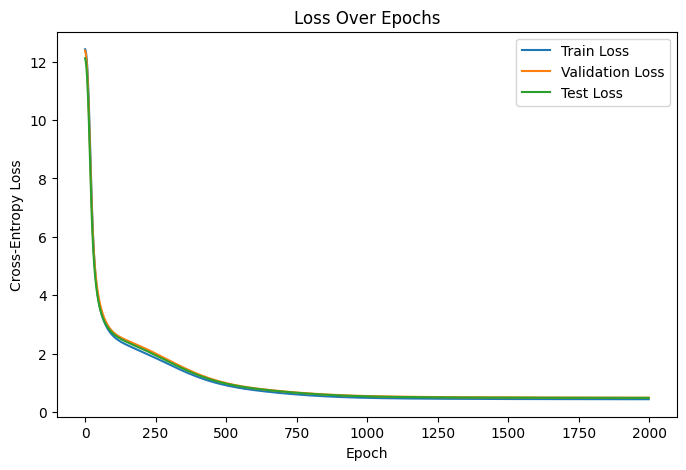

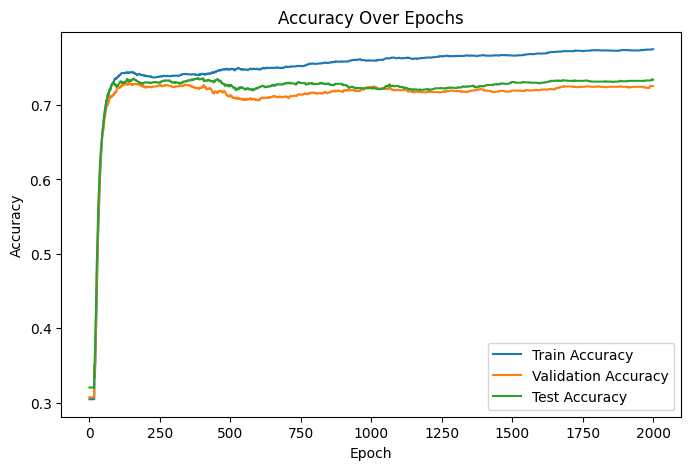

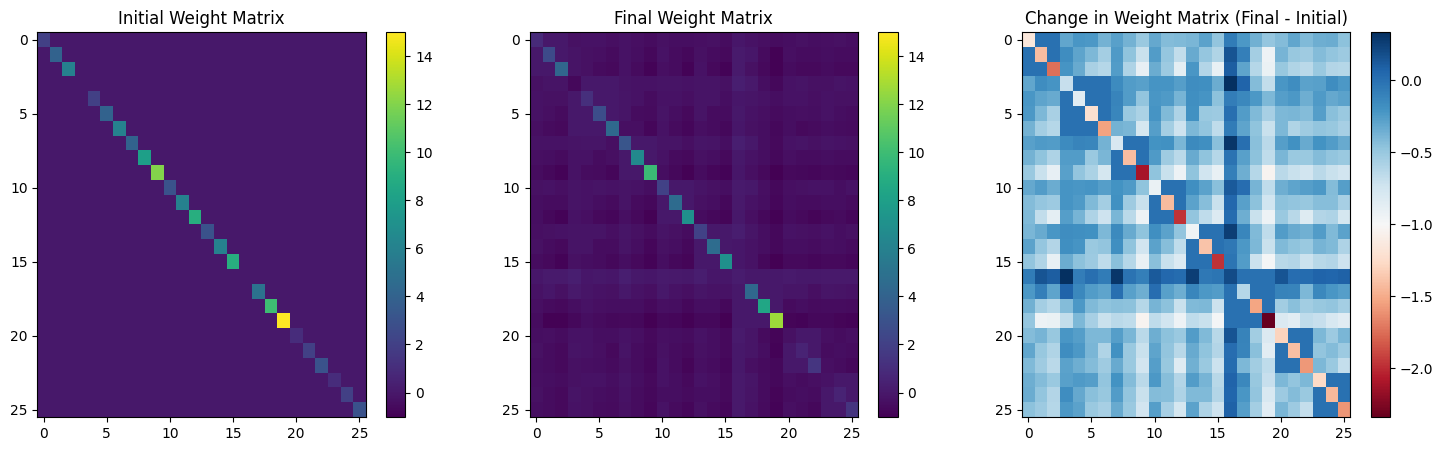

In [33]:
# Plot training, validation, and test loss curves.
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.plot(test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

vmin = min(W_init.min(), W.min())
vmax = max(W_init.max(), W.max())

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
im0 = axs[0].imshow(W_init, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title("Initial Weight Matrix")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(W, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title("Final Weight Matrix")
plt.colorbar(im1, ax=axs[1])
W_diff = W - W_init
im2 = axs[2].imshow(W_diff, aspect='auto', cmap='RdBu')
axs[2].set_title("Change in Weight Matrix (Final - Initial)")
plt.colorbar(im2, ax=axs[2])
plt.show()

In [34]:
# print(np.diag(W))
# print(np.diag(W_init))
# print(np.diag(np.abs(W-W_init)))

In [35]:
# import pickle
# with open ('../models/26x26/W_1.pkl', 'wb') as f:
#     pickle.dump(W,f)

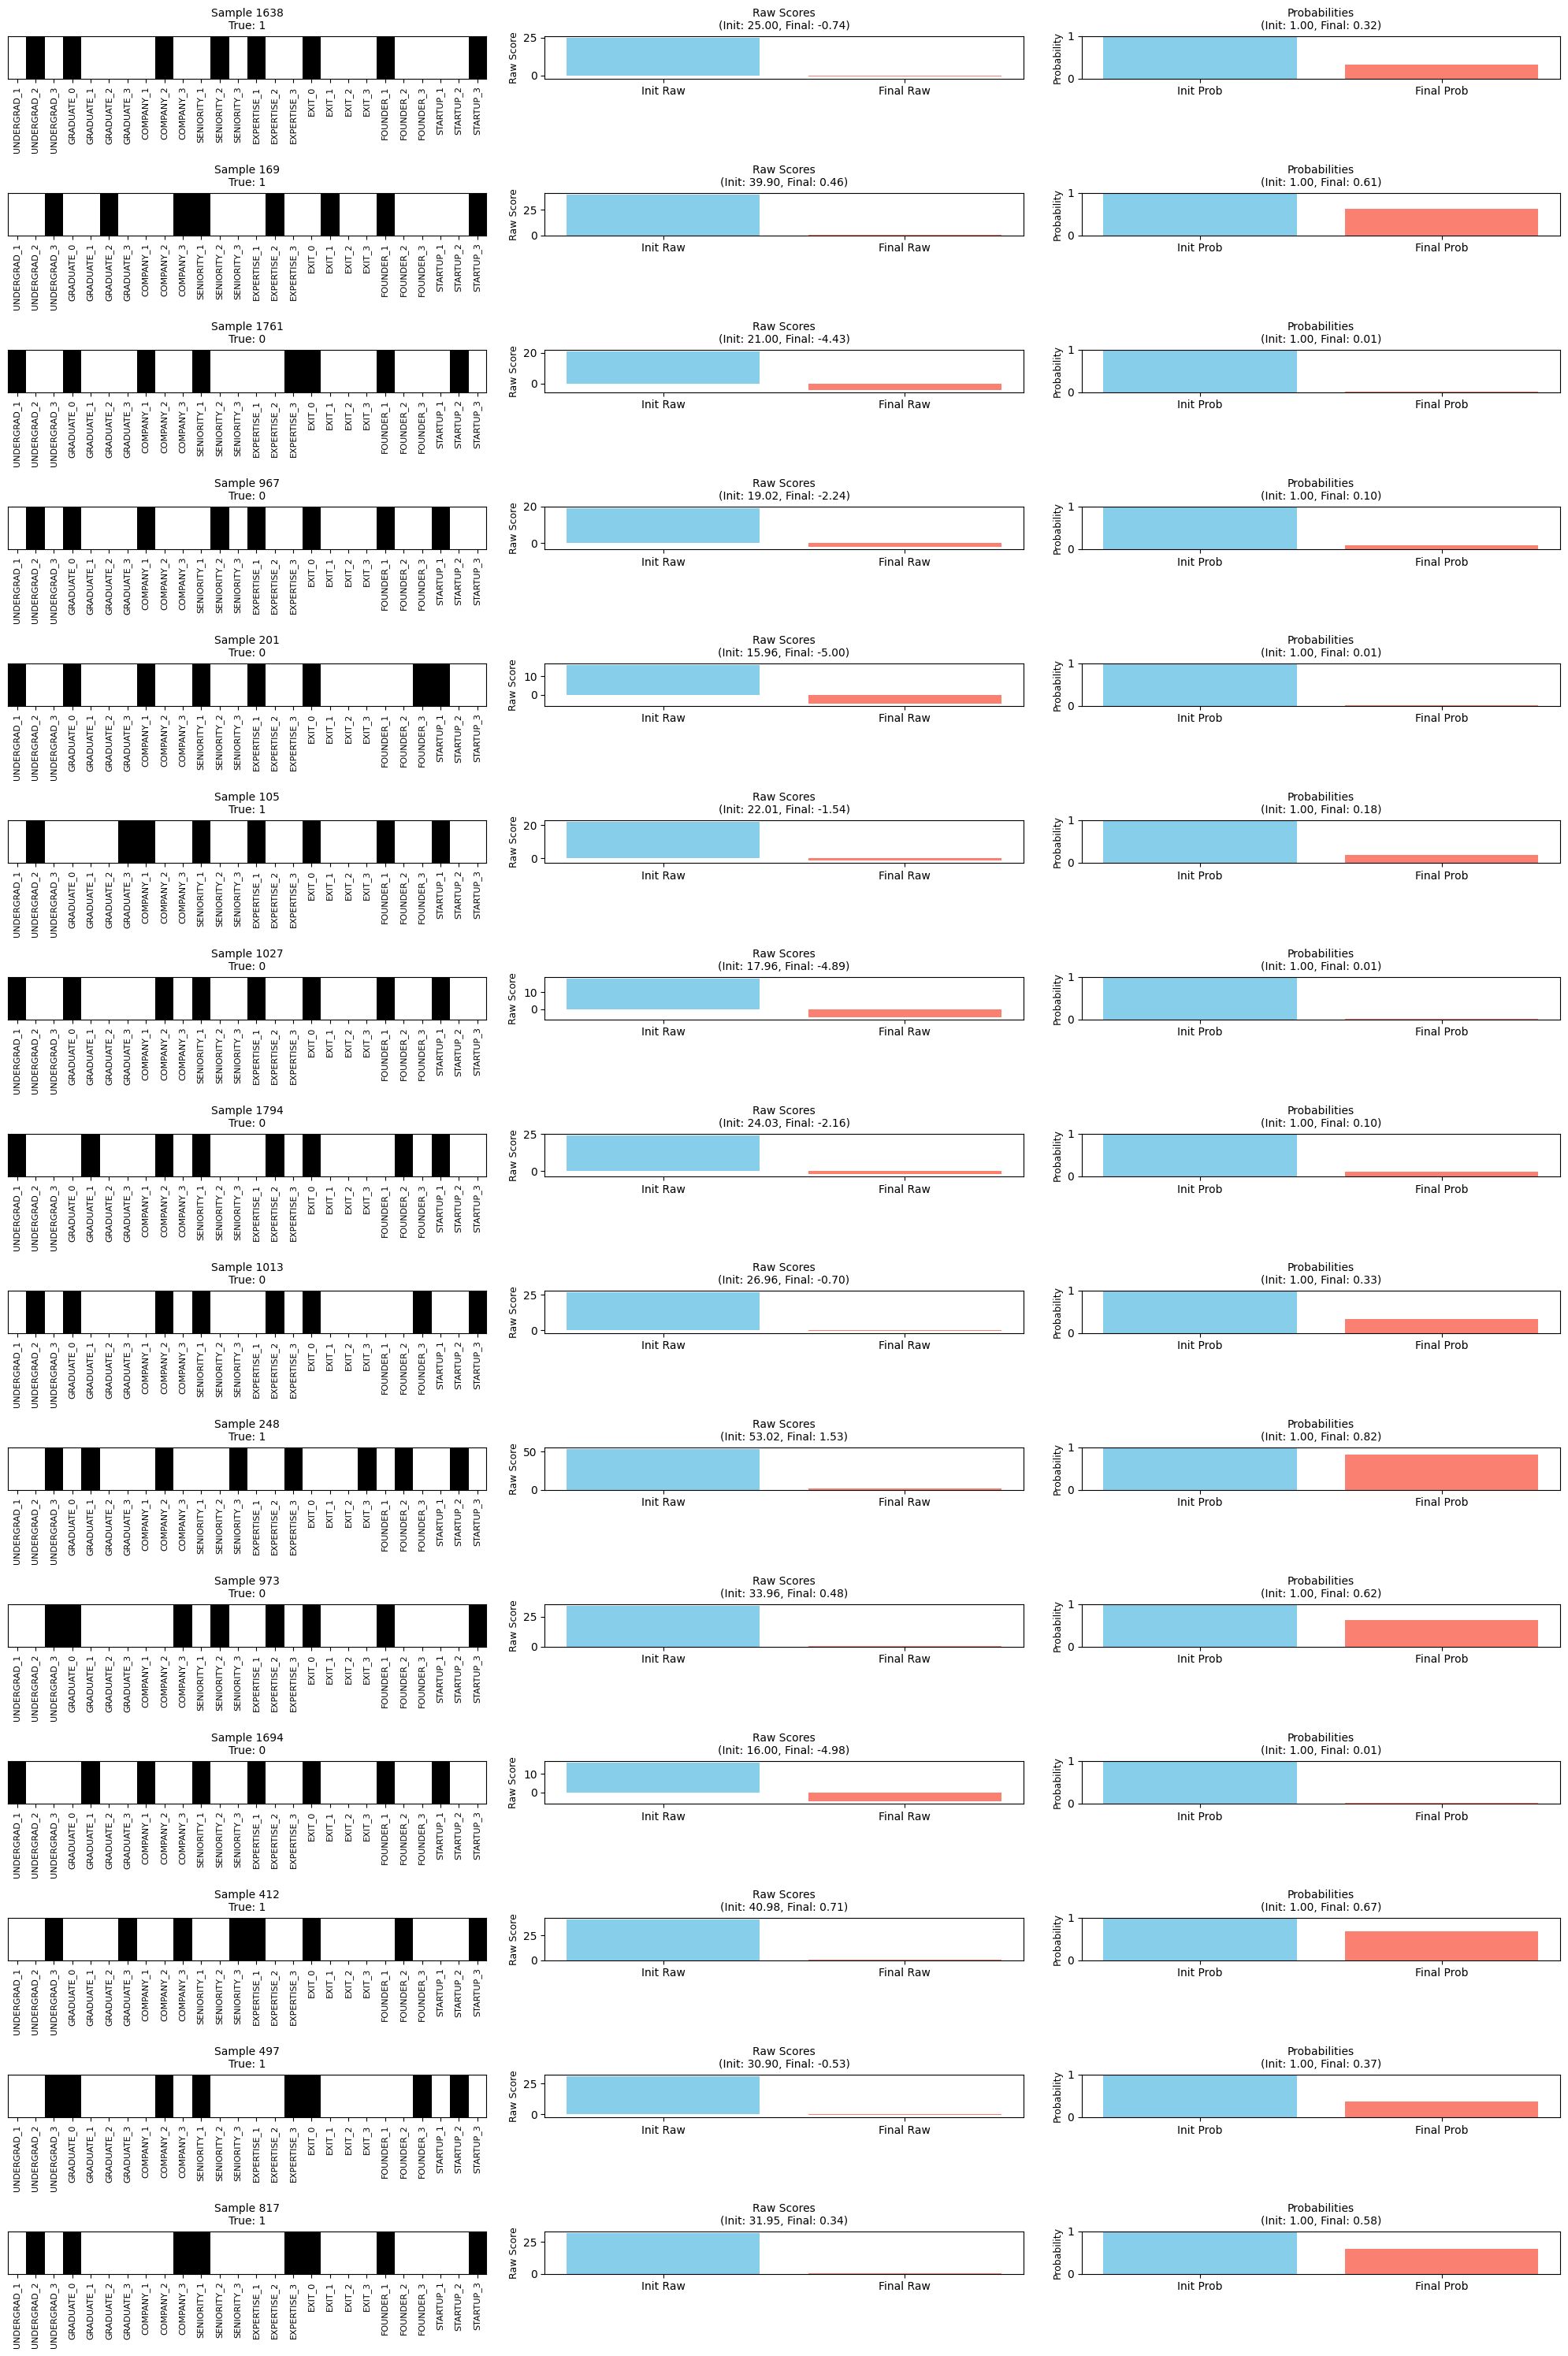

In [36]:
X_raw = df[feature_columns].to_numpy()

X_raw_train, X_raw_test, _, _ = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, shuffle=True
)

n_samples = 15
selected_indices = np.random.choice(len(X_test), size=n_samples, replace=False)
selected_samples = X_test[selected_indices]
selected_y_true = y_test[selected_indices]
selected_raw_attributes = X_raw_test[selected_indices]

raw_scores_init = np.array([x.T @ W_init @ x for x in selected_samples])
raw_scores_final = np.array([x.T @ W @ x + b for x in selected_samples])

p_init = sigmoid(raw_scores_init)
p_final = sigmoid(raw_scores_final)

fig, axs = plt.subplots(n_samples, 3, figsize=(20, 2 * n_samples))
if n_samples == 1:
    axs = axs[np.newaxis, :]

for i in range(n_samples):
    ax_attr = axs[i, 0]
    sample_data = selected_raw_attributes[i].reshape(1, -1)
    im = ax_attr.imshow(sample_data, cmap='Greys', aspect='auto')
    ax_attr.set_yticks([])
    ax_attr.set_xticks(np.arange(len(feature_columns)))
    ax_attr.set_xticklabels(feature_columns, rotation=90, fontsize=8)
    ax_attr.set_title(f"Sample {selected_indices[i]}\nTrue: {selected_y_true[i]}", fontsize=10)
    
    ax_raw = axs[i, 1]
    categories = ['Init Raw', 'Final Raw']
    raw_vals = [raw_scores_init[i], raw_scores_final[i]]
    ax_raw.bar(categories, raw_vals, color=['skyblue', 'salmon'])
    ax_raw.set_ylabel("Raw Score", fontsize=9)
    ax_raw.set_title(f"Raw Scores\n(Init: {raw_scores_init[i]:.2f}, Final: {raw_scores_final[i]:.2f})", fontsize=10)
    
    ax_prob = axs[i, 2]
    prob_categories = ['Init Prob', 'Final Prob']
    prob_vals = [p_init[i], p_final[i]]
    ax_prob.bar(prob_categories, prob_vals, color=['skyblue', 'salmon'])
    ax_prob.set_ylim(0, 1)
    ax_prob.set_ylabel("Probability", fontsize=9)
    ax_prob.set_title(f"Probabilities\n(Init: {p_init[i]:.2f}, Final: {p_final[i]:.2f})", fontsize=10)

plt.tight_layout()
plt.show()

In [37]:
from sklearn.metrics import classification_report

test_preds = (test_probs > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_test, test_preds))



Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.81      1359
           1       0.59      0.55      0.57       641

    accuracy                           0.73      2000
   macro avg       0.69      0.68      0.69      2000
weighted avg       0.73      0.73      0.73      2000

